<a href="https://colab.research.google.com/github/kkharon/iS/blob/main/Task_13_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.layers import SimpleRNN
from keras.layers import GRU
%matplotlib inline

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

Вариант 5

In [ ]:
# id авиационного двигателя в наборе данных.

ID = 5

np.random.seed(1234)

PYTHONHASHSEED = 0

In [ ]:
# Data ingestion - reading the datasets from Azure blob
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt

--2024-02-27 07:40:01--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.59, 13.107.213.59, 2620:1ec:bdf::59, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt’

PM_train.txt        100%[===================>]   3.35M  2.15MB/s    in 1.6s    

2024-02-27 07:40:04 (2.15 MB/s) - ‘PM_train.txt’ saved [3515356/3515356]

--2024-02-27 07:40:04--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.59, 13.107.213.59, 2620:1ec:bdf::59, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt’

PM_test.txt

In [ ]:
# read training data
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
train_df = train_df[train_df.id == ID]

In [ ]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
test_df = test_df[test_df.id == ID]

In [ ]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [ ]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
847,5,1,0.0031,0.0002,100.0,518.67,641.77,1583.59,1395.26,14.62,...,522.34,2388.00,8152.22,8.4102,0.03,393,2388,100.0,38.98,23.4468
848,5,2,0.0002,0.0003,100.0,518.67,642.42,1589.69,1394.88,14.62,...,522.60,2387.99,8153.04,8.4053,0.03,392,2388,100.0,39.12,23.4075
849,5,3,0.0002,-0.0005,100.0,518.67,642.07,1582.45,1396.29,14.62,...,522.85,2388.02,8148.42,8.3990,0.03,393,2388,100.0,39.18,23.3298
850,5,4,0.0017,-0.0004,100.0,518.67,642.08,1586.84,1397.94,14.62,...,522.11,2387.99,8148.81,8.3876,0.03,390,2388,100.0,39.22,23.4306
851,5,5,-0.0007,0.0001,100.0,518.67,642.03,1581.45,1394.28,14.62,...,522.60,2387.95,8147.69,8.4129,0.03,390,2388,100.0,39.17,23.3331


In [ ]:
train_df.shape

(269, 26)

In [ ]:
test_df.shape

(98, 26)

## Data Preprocessing
First step is to generate labels for the training data which are Remaining Useful Life (RUL), label1 and label2 as was done in the [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3). Here, we will only make use of "label1" for binary clasification, while trying to answer the question: is a specific engine going to fail within w1 cycles?

In [ ]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,5,1,0.0031,0.0002,100.0,518.67,641.77,1583.59,1395.26,14.62,...,2388.00,8152.22,8.4102,0.03,393,2388,100.0,38.98,23.4468,268
1,5,2,0.0002,0.0003,100.0,518.67,642.42,1589.69,1394.88,14.62,...,2387.99,8153.04,8.4053,0.03,392,2388,100.0,39.12,23.4075,267
2,5,3,0.0002,-0.0005,100.0,518.67,642.07,1582.45,1396.29,14.62,...,2388.02,8148.42,8.3990,0.03,393,2388,100.0,39.18,23.3298,266
3,5,4,0.0017,-0.0004,100.0,518.67,642.08,1586.84,1397.94,14.62,...,2387.99,8148.81,8.3876,0.03,390,2388,100.0,39.22,23.4306,265
4,5,5,-0.0007,0.0001,100.0,518.67,642.03,1581.45,1394.28,14.62,...,2387.95,8147.69,8.4129,0.03,390,2388,100.0,39.17,23.3331,264


In [ ]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,5,1,0.0031,0.0002,100.0,518.67,641.77,1583.59,1395.26,14.62,...,8.4102,0.03,393,2388,100.0,38.98,23.4468,268,0,0
1,5,2,0.0002,0.0003,100.0,518.67,642.42,1589.69,1394.88,14.62,...,8.4053,0.03,392,2388,100.0,39.12,23.4075,267,0,0
2,5,3,0.0002,-0.0005,100.0,518.67,642.07,1582.45,1396.29,14.62,...,8.3990,0.03,393,2388,100.0,39.18,23.3298,266,0,0
3,5,4,0.0017,-0.0004,100.0,518.67,642.08,1586.84,1397.94,14.62,...,8.3876,0.03,390,2388,100.0,39.22,23.4306,265,0,0
4,5,5,-0.0007,0.0001,100.0,518.67,642.03,1581.45,1394.28,14.62,...,8.4129,0.03,390,2388,100.0,39.17,23.3331,264,0,0


In [ ]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,5,1,0.796610,0.7,0.0,0.0,0.172794,0.253973,0.133700,0.0,...,0.0,0.444444,0.0,0.0,0.673684,0.805011,268,0,0,0.000000
1,5,2,0.550847,0.8,0.0,0.0,0.411765,0.430222,0.125330,0.0,...,0.0,0.333333,0.0,0.0,0.821053,0.730972,267,0,0,0.003731
2,5,3,0.550847,0.0,0.0,0.0,0.283088,0.221034,0.156388,0.0,...,0.0,0.444444,0.0,0.0,0.884211,0.584589,266,0,0,0.007463
3,5,4,0.677966,0.1,0.0,0.0,0.286765,0.347876,0.192731,0.0,...,0.0,0.111111,0.0,0.0,0.926316,0.774491,265,0,0,0.011194
4,5,5,0.474576,0.6,0.0,0.0,0.268382,0.192141,0.112115,0.0,...,0.0,0.111111,0.0,0.0,0.873684,0.590806,264,0,0,0.014925


In [ ]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,5,1,0.737288,0.1,0.0,0.0,0.415441,0.462005,0.282599,0.0,...,0.483871,-0.135372,0.474920,0.0,0.555556,0.0,0.0,0.736842,0.701017,0.000000
1,5,2,0.627119,0.7,0.0,0.0,0.569853,0.192430,0.451762,0.0,...,0.612903,-0.164871,0.476521,0.0,0.444444,0.0,0.0,0.557895,0.562547,0.003731
2,5,3,1.008475,0.5,0.0,0.0,0.580882,0.325051,0.406388,0.0,...,0.612903,-0.120286,0.598186,0.0,0.444444,0.0,0.0,0.715789,0.628109,0.007463
3,5,4,0.449153,0.8,0.0,0.0,0.547794,0.321583,0.314537,0.0,...,0.548387,-0.146148,0.326041,0.0,0.333333,0.0,0.0,0.673684,0.636586,0.011194
4,5,5,0.906780,0.7,0.0,0.0,0.500000,0.248483,0.398678,0.0,...,0.290323,-0.110587,0.354856,0.0,0.333333,0.0,0.0,0.652632,0.661266,0.014925


In [ ]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [ ]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,5,1,0.737288,0.1,0.0,0.0,0.415441,0.462005,0.282599,0.0,...,-0.135372,0.474920,0.0,0.555556,0.0,0.0,0.736842,0.701017,0.000000,NaN
1,5,2,0.627119,0.7,0.0,0.0,0.569853,0.192430,0.451762,0.0,...,-0.164871,0.476521,0.0,0.444444,0.0,0.0,0.557895,0.562547,0.003731,NaN
2,5,3,1.008475,0.5,0.0,0.0,0.580882,0.325051,0.406388,0.0,...,-0.120286,0.598186,0.0,0.444444,0.0,0.0,0.715789,0.628109,0.007463,NaN
3,5,4,0.449153,0.8,0.0,0.0,0.547794,0.321583,0.314537,0.0,...,-0.146148,0.326041,0.0,0.333333,0.0,0.0,0.673684,0.636586,0.011194,NaN
4,5,5,0.906780,0.7,0.0,0.0,0.500000,0.248483,0.398678,0.0,...,-0.110587,0.354856,0.0,0.333333,0.0,0.0,0.652632,0.661266,0.014925,NaN


In [ ]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,5,1,0.737288,0.1,0.0,0.0,0.415441,0.462005,0.282599,0.0,...,0.0,0.555556,0.0,0.0,0.736842,0.701017,0.000000,NaN,0,0
1,5,2,0.627119,0.7,0.0,0.0,0.569853,0.192430,0.451762,0.0,...,0.0,0.444444,0.0,0.0,0.557895,0.562547,0.003731,NaN,0,0
2,5,3,1.008475,0.5,0.0,0.0,0.580882,0.325051,0.406388,0.0,...,0.0,0.444444,0.0,0.0,0.715789,0.628109,0.007463,NaN,0,0
3,5,4,0.449153,0.8,0.0,0.0,0.547794,0.321583,0.314537,0.0,...,0.0,0.333333,0.0,0.0,0.673684,0.636586,0.011194,NaN,0,0
4,5,5,0.906780,0.7,0.0,0.0,0.500000,0.248483,0.398678,0.0,...,0.0,0.333333,0.0,0.0,0.652632,0.661266,0.014925,NaN,0,0


In [ ]:
# pick a large window size of 50 cycles
sequence_length = 50

In [ ]:
# preparing data for visualizations
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

In [ ]:
# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [ ]:
# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [ ]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

In [ ]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(219, 50, 25)

In [ ]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [ ]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(219, 1)

Общая функция для построения графиков точности и потерь

In [ ]:
def plot_history():
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')

    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')

    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')

In [ ]:
accuracy_list = []
recall_list = []
precision_list = []
f1_list = []

## LSTM


Первый слой — это слой LSTM со 100 блоками памяти, за которым следует еще один слой LSTM с 50 блоками памяти. Dropout также применяется после каждого слоя LSTM для контроля переобучения. Последний слой представляет собой плотный выходной слой с одним нейроном и сигмовидной активацией, поскольку это проблема бинарной классификации.

In [ ]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Формула: num_params = [(num_units + input_dim + 1) * num_units] * 4

+1 - bias

*4 (умножаем на 4, потому что LSTM слой состоит из четырех основных компонентов: input gate, forget gate, update gate и output gate. Каждый из этих компонент имеет свои собственные веса и смещения, поэтому для каждого блока памяти в LSTM слое требуется учитывать 4 набора параметров (веса и смещения).

Поэтому при расчете общего количества параметров для LSTM слоя мы умножаем количество блоков памяти (units) на 4, чтобы учесть все четыре компонента LSTM.)

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80651 (315.04 KB)
Trainable params: 80651 (315.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None



100 - количество блоков памяти в LSTM

25 - размер входных данных

 4 * 100 * (25 + 100 + 1)  = 4 * 100 * 126 = **50400**


Слой Dropout не имеет параметров для обучения, поэтому в таблице значение 0

Второй слой LSTM:

4 * 50 * (50 + 100 + 1) = **30200**

Последний LSTM слой имеет 50 нейронов, поэтому Dense слой имеет 50 + 1 (смещение) параметр.

In [ ]:
%%time
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/10
7/7 [==============================] - 20s 627ms/step - loss: 0.5149 - accuracy: 0.7740 - val_loss: 2.1268 - val_accuracy: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 0s 29ms/step - loss: 0.2900 - accuracy: 0.9038 - val_loss: 1.5771 - val_accuracy: 0.0000e+00
Epoch 3/10
7/7 [==============================] - 0s 45ms/step - loss: 0.2031 - accuracy: 0.9038 - val_loss: 0.6695 - val_accuracy: 0.8182
Epoch 4/10
7/7 [==============================] - 0s 51ms/step - loss: 0.1097 - accuracy: 0.9519 - val_loss: 0.2936 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0727 - accuracy: 0.9712 - val_loss: 0.2058 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 0s 31ms/step - loss: 0.0808 - accuracy: 0.9808 - val_loss: 0.1393 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 36ms/step - loss: 0.0606 - accuracy: 0.9808 - val_loss: 0.1263 - val_accuracy: 1.0000
Epoch 8/10
7/7 [=

Построим график точности и потерь

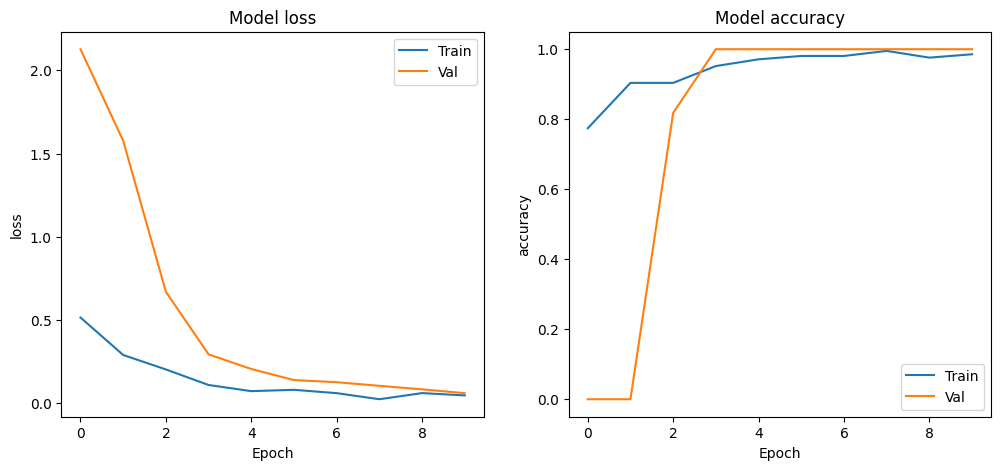

In [ ]:
plot_history()

In [ ]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

2/2 [==============================] - 0s 14ms/step - loss: 0.0489 - accuracy: 0.9817
Accurracy: 0.9817351698875427


In [ ]:
# make predictions and compute confusion matrix
y_pred = np.round(model.predict(seq_array,verbose=1, batch_size=200))
y_true = label_array

2/2 [==============================] - 1s 7ms/step


In [ ]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('LSTM Results:')
print('precision =', precision,)
print('recall =', recall)
print('F1 =', f1)
print('Accuracy =', accuracy)

LSTM Results:
precision = 0.8857142857142857
recall = 1.0
F1 = 0.9393939393939393
Accuracy = 0.9817351598173516


In [ ]:
accuracy_list.append(accuracy)
recall_list.append(recall)
precision_list.append(precision)
f1_list.append(f1)

## RNN

In [ ]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))

model.add(Dense(nb_out, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 100)           12600     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 100)           20100     
                                                                 
 dropout_3 (Dropout)         (None, 50, 100)           0         
                                                                 
 dense_1 (Dense)             (None, 50, 1)             101       
                                                                 
Total params: 32801 (128.13 KB)
Trainable params: 32801 (128.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Расчет параметров:

Веса для входных данных: (25 * 100 = 2500) (так как размер входных данных 25, а количество блоков 100)

Веса для скрытого состояния: (100 * 100 = 10000) (так как у каждого блока памяти есть свое скрытое состояние)

Смещения: 100 (для каждого из 100 блоков памяти)

Итак, общее количество параметров для слоя SimpleRNN:

2500 + 10000 + 100 = **12600**

Для второго слоя RNN

Веса для входных данных: (100 * 100 = 10000) (входные данные - скрытое состояние предыдущего слоя)
Веса для скрытого состояния: (100 * 100 = 10000)
Смещения: 100

Общее количество параметров для второго слоя SimpleRNN:

10000 + 10000 + 100 = **20100**

Полносвязный (Dense слой)

100 * 1 = 100 (с учетом предыдущего слоя с 100 блоками)

Смещение + 1

общее количество параметров для слоя Dense:
100 + 1 = **101**

Total params = 12600 + 20100 + 101 = **32801**

In [ ]:
%%time
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/10
7/7 [==============================] - 4s 121ms/step - loss: 0.5069 - accuracy: 0.7644 - val_loss: 2.3604 - val_accuracy: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 1s 140ms/step - loss: 0.2610 - accuracy: 0.9072 - val_loss: 0.7947 - val_accuracy: 0.4600
Epoch 3/10
7/7 [==============================] - 1s 139ms/step - loss: 0.1888 - accuracy: 0.9187 - val_loss: 0.2341 - val_accuracy: 0.8945
Epoch 4/10
7/7 [==============================] - 1s 84ms/step - loss: 0.1095 - accuracy: 0.9545 - val_loss: 0.1245 - val_accuracy: 0.9400
Epoch 5/10
7/7 [==============================] - 0s 71ms/step - loss: 0.0944 - accuracy: 0.9681 - val_loss: 0.1059 - val_accuracy: 0.9491
Epoch 6/10
7/7 [==============================] - 1s 74ms/step - loss: 0.0749 - accuracy: 0.9761 - val_loss: 0.0938 - val_accuracy: 0.9509
Epoch 7/10
7/7 [==============================] - 0s 70ms/step - loss: 0.0669 - accuracy: 0.9820 - val_loss: 0.0922 - val_accuracy: 0.9545
Epoch 8/10
7/7 [====

Построим график точности и потерь

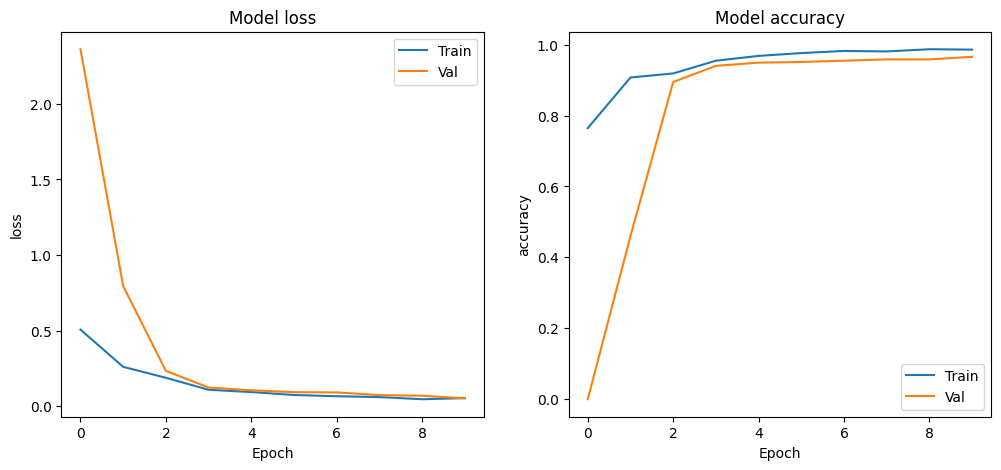

In [ ]:
plot_history()

In [ ]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

2/2 [==============================] - 0s 13ms/step - loss: 0.2621 - accuracy: 0.9361
Accurracy: 0.9360730648040771


In [ ]:
# make predictions and compute confusion matrix
y_pred = np.argmax(model.predict(seq_array,verbose=1, batch_size=200),axis=1)
y_pred[y_pred != 0] = 1

2/2 [==============================] - 0s 12ms/step


In [ ]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('LSTM Results:')
print('precision =', precision,)
print('recall =', recall)
print('F1 =', f1)
print('Accuracy =', accuracy)

LSTM Results:
precision = 0.4696969696969697
recall = 1.0
F1 = 0.6391752577319588
Accuracy = 0.8401826484018264


In [ ]:
accuracy_list.append(accuracy)
recall_list.append(recall)
precision_list.append(precision)
f1_list.append(f1)

## GRU

In [ ]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(GRU(units=100, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))

model.add(GRU(units=100, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
# Compiling the RNN
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 100)           38100     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 50, 100)           60600     
                                                                 
 dropout_5 (Dropout)         (None, 50, 100)           0         
                                                                 
 dense_2 (Dense)             (None, 50, 1)             101       
                                                                 
Total params: 98801 (385.94 KB)
Trainable params: 98801 (385.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


расчитаем параметры

3 * (100 * (100 + 25 + 2 * 1)) = **38100**

(умножаем сумму на 3, так как у GRU есть три весовых матрицы: обновление, сброс и новое содержание)

2 слой GRU:

3 * (100 * (100 + 100 + 2 * 1)) = **60600**

Полносвязный (Dense слой)

100 * 1 = 100 (с учетом предыдущего слоя с 100 блоками)

Смещение + 1

общее количество параметров для слоя Dense:
100 + 1 = **101**

Total params = 38100 + 60600 + 101 = **98801**

In [ ]:
%%time
# fit the network
history = model.fit(seq_array, label_array, epochs=10, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/10
7/7 [==============================] - 5s 170ms/step - loss: 0.5019 - accuracy: 0.7841 - val_loss: 2.3254 - val_accuracy: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 0s 20ms/step - loss: 0.3243 - accuracy: 0.9038 - val_loss: 2.1958 - val_accuracy: 0.0000e+00
Epoch 3/10
7/7 [==============================] - 0s 18ms/step - loss: 0.2627 - accuracy: 0.9040 - val_loss: 0.8625 - val_accuracy: 0.3400
Epoch 4/10
7/7 [==============================] - 0s 19ms/step - loss: 0.2067 - accuracy: 0.9260 - val_loss: 0.5265 - val_accuracy: 0.6600
Epoch 5/10
7/7 [==============================] - 0s 17ms/step - loss: 0.1458 - accuracy: 0.9387 - val_loss: 0.1708 - val_accuracy: 0.9055
Epoch 6/10
7/7 [==============================] - 0s 15ms/step - loss: 0.1425 - accuracy: 0.9362 - val_loss: 0.2602 - val_accuracy: 0.8545
CPU times: user 5.38 s, sys: 97.7 ms, total: 5.48 s
Wall time: 5.59 s


Построим график точности и потерь

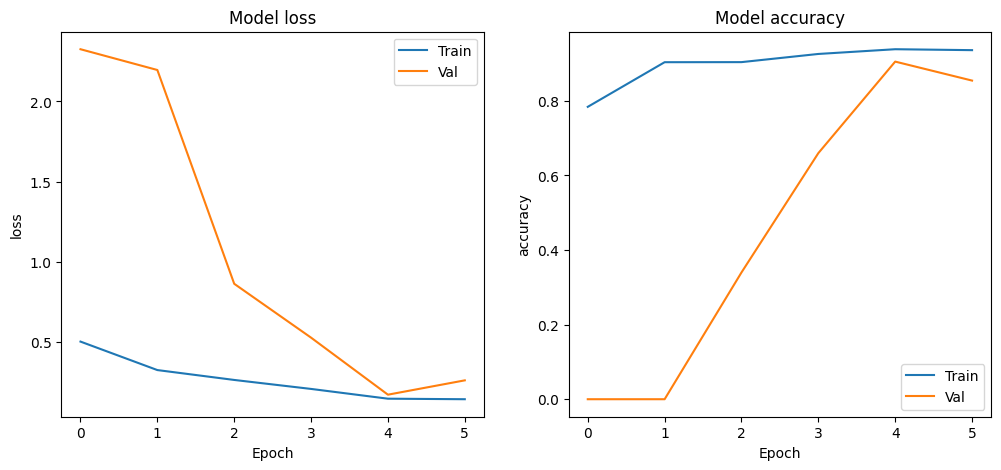

In [ ]:
plot_history()

In [ ]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

2/2 [==============================] - 0s 14ms/step - loss: 0.1433 - accuracy: 0.9379
Accurracy: 0.9378995299339294


In [ ]:
# make predictions and compute confusion matrix
y_pred = np.argmax(model.predict(seq_array,verbose=1, batch_size=200),axis=1)
y_pred[y_pred != 0] = 1

2/2 [==============================] - 1s 13ms/step


In [ ]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('LSTM Results:')
print('precision =', precision,)
print('recall =', recall)
print('F1 =', f1)
print('Accuracy =', accuracy)

LSTM Results:
precision = 0.62
recall = 1.0
F1 = 0.7654320987654321
Accuracy = 0.91324200913242


In [ ]:
accuracy_list.append(accuracy)
recall_list.append(recall)
precision_list.append(precision)
f1_list.append(f1)

## Результирующая таблица:

In [ ]:
results_df = pd.DataFrame({'Accuracy': accuracy_list, 'Precision': precision_list, 'Recall': recall_list, 'F1-score': f1_list},
                         index = ['LSTM', 'RNN', 'GRU'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.981735,0.885714,1.0,0.939394
RNN,0.840183,0.469697,1.0,0.639175
GRU,0.913242,0.620000,1.0,0.765432


Лучший результат показала сеть **RNN**

Худший - у GRU. Это можно объяснить тем, что GRU - это более простая версия рекуррентной нейронной сети, которая объединяет некоторые характеристики LSTM, но имеет меньше параметров.

Время выполнения

In [ ]:
# хардкод времени обучения LSTM, RNN, GRU при запуске на CPU
cpu_time = [9.31, 5.61 ,12.1]

# хардкод времени обучения LSTM, RNN, GRU при запуске на GPU
gpu_time = [7.01, 8.27, 5.59]

models = ['LSTM', 'RNN', 'GRU']

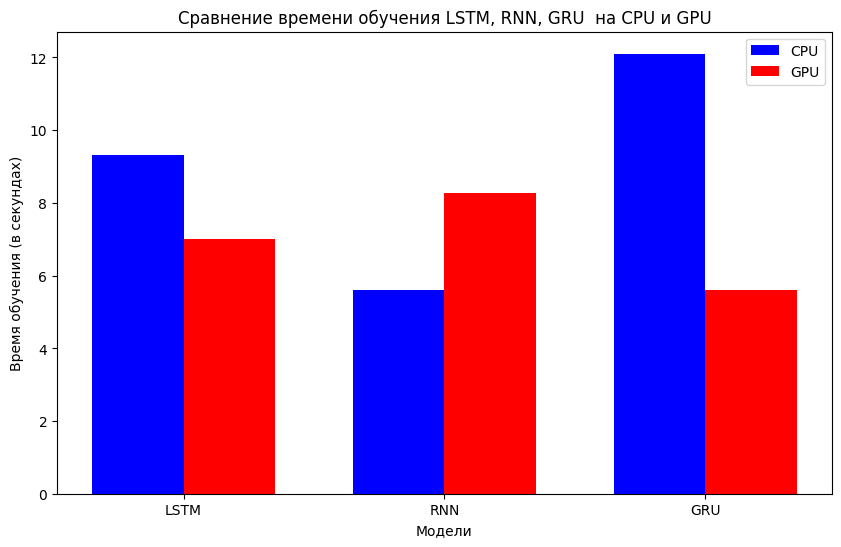

In [ ]:
# Ширина одной колонки
bar_width = 0.35
index = np.arange(len(models))

# Создание графика
plt.figure(figsize=(10, 6))
plt.bar(index - bar_width/2, cpu_time, bar_width, color='b', label='CPU')
plt.bar(index + bar_width/2, gpu_time, bar_width, color='r', label='GPU')

plt.xlabel('Модели')
plt.ylabel('Время обучения (в секундах)')
plt.title('Сравнение времени обучения LSTM, RNN, GRU  на CPU и GPU')
plt.legend()
plt.xticks(index, models)
plt.show()

Так как набор данных не очень большой, то разница между временем выполнения на GRU и CPU незначительная. Интересно, что в случае с RNN моделью время выполнения на CPU оказалось меньше. Это может быть связано с тем, что мы имеем дело с небольшим объемом данных. Графический процессор (GPU) обычно используется для параллельной обработки больших объемов данных. Или же это может быть связано с особенностью архитектуры модели RNN

Самая большая разница между CPU и GPU у модели GRU.